# 10-403: Homework 2 - P2 - GCBC

1.   List item
2.   List item



You will implement this assignment right here in this Colab notebook. Colab is a Jupyter notebook that runs in the cloud. If you haven't used Colab before, we recommend checking out the following tutorial:
https://colab.sandbox.google.com/notebooks/welcome.ipynb.
Note that all cells modify the same global state, so imported packages as well as functions and variables declared in one cell will be accessible in other cells.


To get started, click the ``File-> Save a copy in Drive`` button in the upper right to work in your drive, otherwise your change in this notebook cannot be saved. In the future, you will be able to find the notebook by looking in your Google drive folder.

Now, you're ready start coding. You will want to run each cell in this notebook by clicking the "play" button to the left of the cell (or using [ctrl -> enter]. Look for ``WRITE CODE HERE`` to identify places where you need to write some code.

When you're done, copy plots genetated by your code into the solution boxes in the submission LaTeX file released with this assignment. In addition to uploading your PDF submission to GradeScope (one per group), you should also upload your code. To do this, explort the code from this notebook (File -> Export.py), and then upload the .py file to GradeScope.



### Setup: Import Dependencies


In [ ]:
from collections import OrderedDict 
import gym
from gym import spaces
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import random

### Make the TF Model
We'll use the same architecture for each of the problems. **This is same as Problem 1, thus you can directly copy your answer here.**


In [ ]:
def make_model(input_dim=4, out_dim=2):
  model = Sequential()      
  # WRITE CODE HERE
  # Add layers to the model:
  # a fully connected layer with 10 units
  # a tanh activation
  # another fully connected layer with out_dim (the number of actions)
  # a softmax activation (so the output is a proper distribution)

  model.add(keras.Input(input_dim,))
  model.add(Dense(10, activation='tanh'))
  model.add(Dense(out_dim, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
  
  # We expect the model to have four weight variables (a kernel and bias for
  # both layers)
  assert len(model.weights) == 4, 'Model should have 4 weights.'
  return model

### Test the model
To confirm that the model is correct, we'll use it to solve a binary classification problem. The target function $f: \mathbb{R}^4 \rightarrow {0, 1}$ indicates whether the sum of the vector coordinates is positive:
$$f(x) = \delta \left(\sum_{i=1}^4 x_i > 0 \right)$$

You should achieve an accuracy of at least 98%.

In [ ]:
model = make_model()
for t in range(20):
  X = np.random.normal(size=(1000, 4))  # some random data
  is_positive = np.sum(X, axis=1) > 0  # A simple binary function
  Y = np.zeros((1000, 2))
  Y[np.arange(1000), is_positive.astype(int)] = 1  # one-hot labels
  history = model.fit(X, Y, epochs=10, batch_size=256, verbose=0)
  loss = history.history['loss'][-1]
  acc = history.history['accuracy'][-1]
  print('(%d) loss= %.3f; accuracy = %.1f%%' % (t, loss, 100 * acc))

(0) loss= 0.667; accuracy = 59.5%
(1) loss= 0.570; accuracy = 72.4%
(2) loss= 0.465; accuracy = 82.1%
(3) loss= 0.411; accuracy = 87.5%
(4) loss= 0.348; accuracy = 90.9%
(5) loss= 0.294; accuracy = 94.7%
(6) loss= 0.254; accuracy = 95.2%
(7) loss= 0.236; accuracy = 96.9%
(8) loss= 0.198; accuracy = 97.2%
(9) loss= 0.189; accuracy = 97.8%
(10) loss= 0.167; accuracy = 97.6%
(11) loss= 0.160; accuracy = 98.5%
(12) loss= 0.143; accuracy = 98.8%
(13) loss= 0.131; accuracy = 98.5%
(14) loss= 0.129; accuracy = 98.9%
(15) loss= 0.119; accuracy = 99.2%
(16) loss= 0.103; accuracy = 99.1%
(17) loss= 0.104; accuracy = 99.1%
(18) loss= 0.090; accuracy = 99.7%
(19) loss= 0.092; accuracy = 99.4%


## Build Goal-Conditioned Task


As the first step, you will implement the environment `FourRooms` by its `step()` function. The vector of scalar action `a` is defined as `self.act_set[a]`. The dynamics is to attempt to move current position `self.s` towards the next position by *adding* the action vector unless the next position is the wall (it will stay at original position). 

The goal is fixed through the transition. The reward is constant zero and not used in this problem.

The episode will end in the two scenarios:
- next position is exactly the goal: success
- time is over `self.t == self.T`: failure

Please differentiate the two scenarios in `info` as you will use `info` in evaluation function `evaluate_gc`.

The `render_map()` visualizes the map.





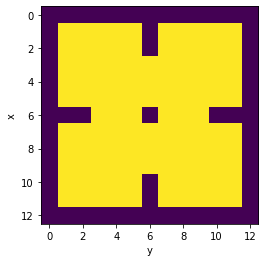

In [ ]:
### 2.1 Build Goal-Conditioned Task
class FourRooms:
    def __init__(self, l=5, T=30):
      # '''
      # FourRooms Environment for pedagogic purposes
      #   Each room is a l*l square gridworld,
      #   connected by four narrow corridors,
      #   the center is at (l+1, l+1).
      #   There are two kinds of walls:
      #   - borders: x = 0 and 2*l+2 and y = 0 and 2*l+2
      #   - central walls
      #   T: maximum horizion of one episode
      #       should be larger than O(4*l)
      #   '''
        assert l % 2 == 1 and l >= 5
        self.l = l
        self.total_l = 2 * l + 3
        self.T = T

    # create a map: zeros (walls) and ones (valid grids)
        self.map = np.ones((self.total_l, self.total_l), dtype=np.bool)
        # build walls
        self.map[0, :] = False
        self.map[-1, :] = False
        self.map[:, 0] = False
        self.map[:, -1] = False
        self.map[l+1, [1,2,-3,-2]] = self.map[[1,2,-3,-2], l+1] = False
        self.map[l+1, l+1] = False

        # define action mapping (go right/up/left/down, counter-clockwise)
        # e.g [1, 0] means + 1 in x coordinate, no change in y coordinate hence
        # hence resulting in moving right
        self.act_set = np.array([
            [1, 0], [0, 1], [-1, 0], [0, -1]
        ], dtype=np.int)
        self.action_space = spaces.Discrete(4)

        # you may use self.act_map in search algorithm
        self.act_map = {}
        self.act_map[(1, 0)] = 0
        self.act_map[(0, 1)] = 1
        self.act_map[(-1, 0)] = 2
        self.act_map[(0, -1)] = 3

    def render_map(self):
        plt.imshow(self.map)
        plt.xlabel('y')
        plt.ylabel('x')
        plt.savefig('p2_map.png',
                    bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.show()

    def sample_sg(self):
        # sample s
        while True:
            s = [np.random.randint(self.total_l),
                np.random.randint(self.total_l)]
            if self.map[s[0], s[1]]:
                break

        # sample g
        while True:
            g = [np.random.randint(self.total_l),
                np.random.randint(self.total_l)]
            if self.map[g[0], g[1]] and \
                (s[0] != g[0] or s[1] != g[1]):
                break
        return s, g

    def reset(self, s=None, g=None):
        '''
        s: starting position, np.array((2,))
        g: goal, np.array((2,))
        return obs: np.cat(s, g)
        '''
        if s is None or g is None:
            s, g = self.sample_sg()
        else:
            assert 0 < s[0] < self.total_l - 1 and 0 < s[1] < self.total_l - 1
            assert 0 < g[0] < self.total_l - 1 and 0 < g[1] < self.total_l - 1
            assert (s[0] != g[0] or s[1] != g[1])
            assert self.map[s[0], s[1]] and self.map[g[0], g[1]]

        self.s = s
        self.g = g
        self.t = 1

        return self._obs()

    def step(self, a):
        # '''
        # a: action, a scalar
        # return obs, reward, done, info
        # - done: whether the state has reached the goal
        # - info: succ if the state has reached the goal, fail otherwise
        # '''
        assert self.action_space.contains(a)

        # WRITE CODE HERE
        # print("curr state",self.s)
        # # print("action ", self.act_set[a])
        done = False
        next_state = self.s+self.act_set[a]
        # print('next state', next_state)
        info = 'fail'
        if self.t == self.T:
            # print("done " , self.T)
            done = True
        elif next_state[0] == self.g[0] and next_state[1] == self.g[1]:
            done = True
            # print("goal")
            info = "succ"
            self.s = next_state
            self.t+=1
        elif not self.map[next_state[0],next_state[1]]:
            self.t+=1
            # print(self.map[next_state])
            # print("obstacle")
        else:
            self.t+=1
            # print("valid")
            self.s = next_state

        # END

        return self._obs(), 0.0, done, info

    def _obs(self):
        return np.concatenate([self.s, self.g])

# build env
l, T = 5, 30
env = FourRooms(l, T)
### Visualize the map
env.render_map()


To test your `step()` implementation, please run the cell below to plot one trajectory of a uniform policy.

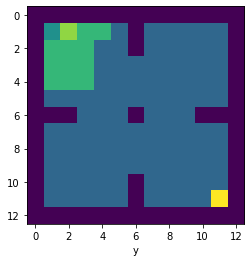

In [ ]:
### A uniformly random policy's trajectory
s = np.array([1, 1])
g = np.array([2*l+1, 2*l+1])
s = env.reset(s, g)
done = False
traj = [s]
while not done:
	s, _, done, _ = env.step(env.action_space.sample())
	traj.append(s)
traj = np.array(traj)

def plot_traj(env, ax, traj, goal=None):
	traj_map = env.map.copy().astype(np.float)
	traj_map[traj[:, 0], traj[:, 1]] = 2 # visited states
	traj_map[traj[0, 0], traj[0, 1]] = 1.5 # starting state
	traj_map[traj[-1, 0], traj[-1, 1]] = 2.5 # ending state
	if goal is not None:
		traj_map[goal[0], goal[1]] = 3 # goal
	ax.imshow(traj_map)
	ax.set_xlabel('y')
	ax.set_label('x')

ax = plt.subplot()
plot_traj(env, ax, traj, g)
plt.savefig('p2_random_traj.png', 
		 bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

## Shortest-Path Expert

Since this is a classic maze problem, you can exactly solve it by any shortest-path search algorithms, such as breadth-first search (BFS) and Dijkstra's algorithm. Please implement any shortest-path algorithm on this environment.

After you implement the expert algorithm, please collect $N=1000$ expert trajectories in this environment, with `expert_trajs` as a list of expert state trajectories, and `expert_actions` as the corresponding list of expert action sequences. For each trajectory, you can use `env.sample_sg()` sample the starting state $s$ and the goal $g$ uniformly over the valid grids s.t. $s\neq g$.

In [ ]:
from queue import Queue
N = 1000
expert_trajs = []
expert_actions = []

# WRITE CODE HERE
def BFS(env):
  curr_state, goal = env.sample_sg()
  q = Queue()
  curr_traj = [curr_state]
  curr_action = []
  seen = set({})
  seen.add((curr_state[0],curr_state[1]))
  q.put((curr_traj, curr_action, 0))
  
  min_dst=None
  expert_traj = None
  expert_action = None
  curr_dst=0
  while not q.empty():
    curr_traj, curr_action, curr_dst = q.get()
    curr_state = curr_traj[-1]
    
    if(curr_state[0] == goal[0] and curr_state[1] == goal[1]):
      if(expert_traj == None or curr_dst < min_dst):
        expert_traj = curr_traj[:-1]
        expert_action = curr_action
        min_dst =curr_dst

    for i in range(len(env.act_set)):
      action = env.act_set[i]
      next_state = curr_state + action
      
      # print("next ", type(next_state))
      if(env.map[next_state[0], next_state[1]]):
        if not ((next_state[0],next_state[1]) in seen):
          q.put((curr_traj + [next_state], curr_action + [action],curr_dst+1))
          seen.add((next_state[0],next_state[1]))

  assert(len(expert_traj) == len(expert_action))
  return expert_traj, expert_action, goal

for _ in range(N):
  traj, actions,_ = BFS(env)
  expert_trajs += [np.array(traj)]
  expert_actions += [np.array(actions)]
# expert_trajs = np.array(expert_trajs)
# expert_actions = np.array(expert_actions)
# print("shapes ", len(expert_trajs), expert_actions[0].shape)
# END
# You should obtain expert_trajs, expert_actions from search algorithm

plot a subset of expert trajectories

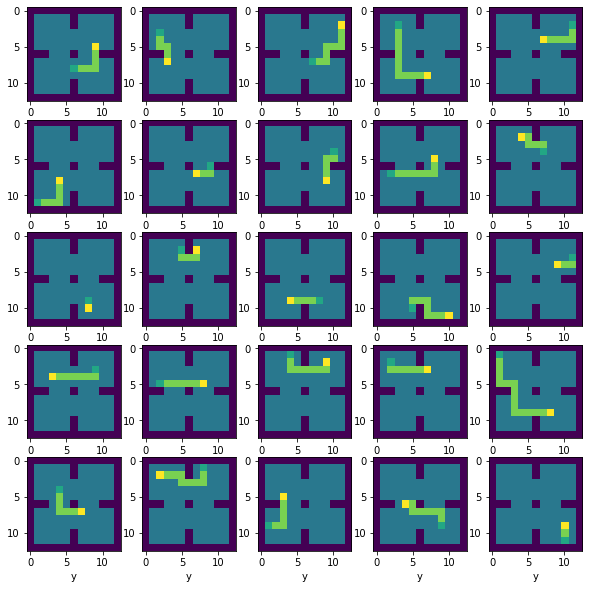

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.reshape(-1)
for idx, ax in enumerate(axes):
  plot_traj(env, ax, expert_trajs[idx])

plt.savefig('p2_expert_trajs.png', 
		 bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

## Train GCBC

For vanilla GCBC, implement `generate_behavior_cloning_data()` and `train()` like Problem 1.

For expert relabelling trick, implement `generate_relabel_data()`.


In [ ]:
def action_to_one_hot(env, action):
    action_vec = np.zeros(env.action_space.n)
    action_vec[action] = 1
    return action_vec  

class GCBC:

    def __init__(self, env, expert_trajs, expert_actions, random_goals = None):
        self.env = env
        self.expert_trajs = expert_trajs
        self.expert_actions = expert_actions
        self.transition_num = sum(map(len, expert_actions))
        self.model = make_model(input_dim=4, out_dim=4)
        # state_dim + goal_dim = 4
        # action_choices = 4

    def reset_model(self):
        self.model = make_model(input_dim=4, out_dim=4)	

    def generate_behavior_cloning_data(self):
        # 3 you will use action_to_one_hot() to convert scalar to vector
        # state should include goal
        self._train_states = []
        self._train_actions = []
        
        # WRITE CODE HERE
        for _ in range(500):
            states, actions, goal = BFS(self.env)

            for i in range(len(states)):
              states[i] = np.concatenate((states[i],np.array(goal)))
              actions[i] = action_to_one_hot(env,env.act_map[tuple(actions[i].tolist())])
            self._train_states.extend(states)
            self._train_actions.extend(actions)
        # END

        self._train_states = np.array(self._train_states).astype(np.float) # size: (*, 4)
        self._train_actions = np.array(self._train_actions) # size: (*, 4)
    
    def generate_relabel_data(self):
        # 4 apply expert relabelling trick
        self._train_states = []
        self._train_actions = []

        # WRITE CODE HERE
        # END
        for _ in range(500):
          states, actions, goal = BFS(self.env)
          relabel_states = states + [goal]
          for i in range(len(states)-1):
            relabel_idx = np.random.choice(range(i+1, len(states)+1))
            states[i] = np.concatenate((states[i], relabel_states[relabel_idx]))
            actions[i] = action_to_one_hot(env,env.act_map[tuple(actions[i].tolist())])
          states[-1] = np.concatenate((states[-1],np.array(goal)))
          actions[-1] = action_to_one_hot(env,env.act_map[tuple(actions[-1].tolist())])

          self._train_states.extend(states)
          self._train_actions.extend(actions)

        self._train_states = np.array(self._train_states).astype(np.float) # size: (*, 4)
        self._train_actions = np.array(self._train_actions) # size: (*, 4)

    def train(self, num_epochs=20, batch_size=256):
    # """ 3
        # Trains the model on training data generated by the expert policy.
        # Args:
        #   num_epochs: number of epochs to train on the data generated by the expert.
        # 	batch_size
        # Return:
        #   loss: (float) final loss of the trained policy.
        #   acc: (float) final accuracy of the trained policy
        # """
      print("States ", self._train_states.shape)
      print("Actions ", self._train_actions.shape)
      hist = self.model.fit(self._train_states,
                          self._train_actions,
                          epochs=num_epochs,
                          batch_size=batch_size)
        # WRITE CODE HERE
        # END
      return hist.history['loss'][-1], hist.history['accuracy'][-1]*100

Implement eval function



In [ ]:
def evaluate_gc(env, policy, n_episodes=50):
    succs = 0
    for _ in range(n_episodes):
        _,_,_,info = generate_gc_episode(env, policy.model)
        # WRITE CODE HERE
        if info == 'succ':
            succs +=1
        # END
    succs /= n_episodes
    return succs

def generate_gc_episode(env, policy):
    """Collects one rollout from the policy in an environment. The environment
    should implement the OpenAI Gym interface. A rollout ends when done=True. The
    number of states and actions should be the same, so you should not include
    the final state when done=True.
    Args:
        env: an OpenAI Gym environment.
        policy: a keras model
    Returns:
    """
    done = False
    state = env.reset()
    states = [state]
    actions = []
    rewards = []
    while not done:
        # WRITE CODE HERE
        action = np.argmax(policy(np.expand_dims(state,0)))
            # print("action shape ", action)
        state, reward, done, info = env.step(action)
        if not done:
            states.append(state)
        actions.append(action_to_one_hot(env,action))
        rewards.append(reward)
        # END
    return states, actions, rewards, info


Run GCBC by switching mode (problem 2.3 use mode `vanilla`; 2.4 use mode `relabel`)



Streaming output truncated to the last 5000 lines.
Epoch 19/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9242
Epoch 20/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9247
88 0.174 92.47 0.6
SEED  4  iter  89
Generating Relabel data
States  (3687, 4)
Actions  (3687, 4)
Epoch 1/20
15/15 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.9311
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1691 - accuracy: 0.9308
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1684 - accuracy: 0.9349
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9336
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9344
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9336
Epoch 7/20
15/15 [==============================] - 0s 2ms/step -

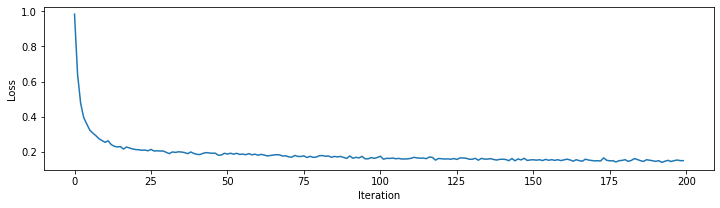

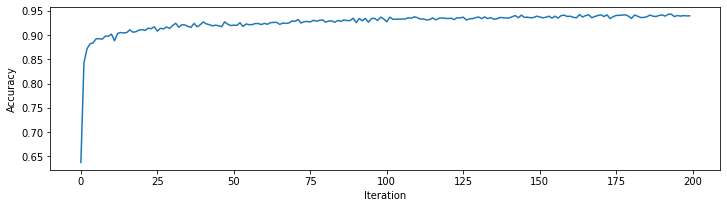

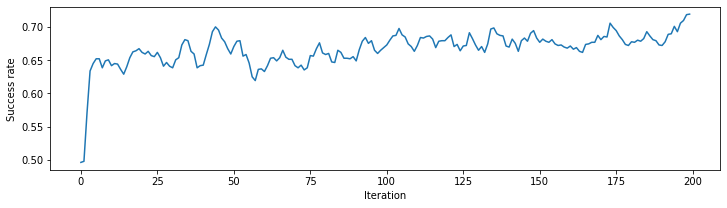

In [ ]:
gcbc = GCBC(env, expert_trajs, expert_actions)
# mode = 'vanilla'
mode = 'relabel'

# print(gcbc._train_states.shape)
# print(gcbc._train_actions.shape)
# print("Model", )
num_seeds = 5
loss_vecs = []
acc_vecs = []
succ_vecs = []

for i in range(num_seeds):
    print('*' * 50)
    print('seed: %d' % i)
    loss_vec = []
    acc_vec = []
    succ_vec = []
    gcbc.reset_model()

    for e in range(200):
        print("SEED ", i, " iter ", e)
        if mode =='vanilla':
            print("Generating Vanilla data")
            gcbc.generate_behavior_cloning_data()
        else:
            print("Generating Relabel data")
            gcbc.generate_relabel_data()
        
        loss, acc = gcbc.train(num_epochs=20)
        succ = evaluate_gc(env, gcbc)
        loss_vec.append(loss)
        acc_vec.append(acc)
        succ_vec.append(succ)
        print(e, round(loss,3), round(acc,3), succ)
    loss_vecs.append(loss_vec)
    acc_vecs.append(acc_vec)
    succ_vecs.append(succ_vec)

loss_vec = np.mean(np.array(loss_vecs), axis = 0).tolist()
acc_vec = np.mean(np.array(acc_vecs), axis = 0).tolist()
succ_vec = np.mean(np.array(succ_vecs), axis = 0).tolist()

### Plot the results
from scipy.ndimage import uniform_filter
# you may use uniform_filter(succ_vec, 5) to smooth succ_vec
succ_vec = uniform_filter(succ_vec, 5)
plt.figure(figsize=(12, 3))
# WRITE CODE HERE
plt.plot(loss_vec, label='loss')
plt.savefig('loss_p2_gcbc_%s.png' % mode, dpi=300)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(12, 3))
plt.plot(np.array(acc_vec) / 100, label='accuracy')
plt.savefig('acc_p2_gcbc_%s.png' % mode, dpi=300)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()
plt.figure(figsize=(12, 3))
plt.plot(succ_vec, label='success rate')
plt.savefig('succ_p2_gcbc_%s.png' % mode, dpi=300)
plt.xlabel("Iteration")
plt.ylabel("Success rate")
# plt.ylim([0,1])
plt.show()
# END



```
# This is formatted as code
```

## Random policy
1. Generate `random_trajs` (and corresponding `random_actions`, `random_goals`) by a random policy
2. Modify the `GCBC` class with extra input `random_goals` to support generate behavior cloning data from behavior policy, and train vanilla GCBC
3. Train relabel GCBC on random policy data

In [ ]:
N = 1000
random_trajs = []
random_actions = []
random_goals = []

# WRITE CODE HERE
for i in range(N):
    state = env.reset()
    done = False
    traj = []
    actions = []
    goal = []
    while not done:
        action = np.random.randint(4)
        state, _, done, _ = env.step(action)
        if done != True:
            traj.append([env.s[0], env.s[1], env.g[0], env.g[1]])
        actions.append(env.act_set[action])
        goal.append(env.g)
    random_trajs.append(traj)
    random_actions.append(actions)
    random_goals.append(goal)

# train GCBC based on the previous code
gcbc = GCBC(env, random_trajs, random_actions)

for mode in ['vanilla', 'relabel']:
    if mode == 'vanilla':
        gcbc.generate_behavior_cloning_data()
    else:
        gcbc.generate_relabel_data()

    print(gcbc._train_states.shape)

    num_seeds = 5
    loss_vecs = []
    acc_vecs = []
    succ_vecs = []

    for i in range(num_seeds):
        print('*' * 50)
        print('seed: %d' % i)
        loss_vec = []
        acc_vec = []
        succ_vec = []
        gcbc.reset_model()

        for e in range(50):
            loss, acc = gcbc.train(num_epochs=20)
            succ = evaluate_gc(env, gcbc)
            loss_vec.append(loss)
            acc_vec.append(acc)
            succ_vec.append(succ)
            print(e, round(loss,3), round(acc,3), succ)
        loss_vecs.append(loss_vec)
        acc_vecs.append(acc_vec)
        succ_vecs.append(succ_vec)

    loss_vec = np.mean(np.array(loss_vecs), axis = 0).tolist()
    acc_vec = np.mean(np.array(acc_vecs), axis = 0).tolist()
    succ_vec = np.mean(np.array(succ_vecs), axis = 0).tolist()

    ### Plot the results
    from scipy.ndimage import uniform_filter
    # you may use uniform_filter(succ_vec, 5) to smooth succ_vec
    plt.figure(figsize=(12, 3))
    X = np.linspace(0, 50, 50)
    plt.plot(X, succ_vec, label="sucess")
    plt.title(mode + " Random Policy Success Rate")
    plt.xlabel("Iteration")
    plt.ylabel("Success rate")
    plt.show()
    plt.figure(figsize=(12, 3))
    plt.plot(X, acc_vec, label="training accuracy")
    plt.title(mode + " Random Policy Training Accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(12, 3))
    plt.plot(X, loss_vec, label="training loss")
    plt.title(mode + " Random Policy Training Loss")
    plt.xlabel("Loss")
    plt.show()

    plt.savefig('p2_gcbc_%s.png' % mode, dpi=300)
    plt.show()


